## Chat Bot Evaluation as Multi-agent Simulation


챗봇, 특히 고객 지원 어시스턴트와 같은 챗봇을 구축할 때 봇의 성능을 적절히 평가하는 것(evaulate)은 어려울 수 있습니다. 

코드 변경이 있을 때마다 수동으로 집중적인 상호 작용을 해야 하는 것은 시간이 많이 소모되는 일입니다.

평가 과정을 더 쉽고 재현 가능하게 만드는 한 가지 방법은 사용자 상호 작용을 시뮬레이션하는 것(simulate a user interaction)입니다.

LangGraph를 사용하면 이를 쉽게 설정할 수 있습니다. 아래는 대화를 시뮬레이션하기 위한 "가상 사용자"(virtual user)를 만드는 방법의 예입니다.

전반적인 시뮬레이션은 다음과 같습니다.

In [ ]:
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community chromadb numexpr

## Define Chat Bot


다음으로 챗봇을 정의합니다. 이 노트북에서는 봇의 API가 메시지 목록을 받아 메시지로 응답한다고 가정합니다. 

이를 업데이트하려면 이 섹션과 아래 시뮬레이터의 "get_messages_for_agent" 함수만 변경하면 됩니다.

my_chat_bot 내의 구현은 설정 가능하며 다른 시스템에서 실행할 수도 있습니다. (예: 시스템이 Python에서 실행되고 있지 않은 경우)


In [1]:
from typing import List

import openai


# This is flexible, but you can define your agent here, or call your agent API here.
def my_chat_bot(messages: List[dict]) -> dict:
    system_message = {
        "role": "system",
        "content": "당신은 항공사의 고객 지원 담당자입니다.",
    }
    messages = [system_message] + messages
    completion = openai.chat.completions.create(
        messages=messages, model="gpt-3.5-turbo"
    )
    return completion.choices[0].message.model_dump()

In [2]:
my_chat_bot([{"role": "user", "content": "안녕!"}])

{'content': '안녕하세요! 어떻게 도와드릴까요?',
 'refusal': None,
 'role': 'assistant',
 'annotations': [],
 'audio': None,
 'function_call': None,
 'tool_calls': None}

## Define Simulated User

*우리는* 이제 시뮬레이션된 사용자를 정의하려고 합니다. 

이는 우리가 원하는 어떤 것이든 될 수 있지만, 이를 LangChain 봇으로 구성할 예정입니다.



In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

system_prompt_template = """당신은 항공사 고객입니다. \
당신은 고객 지원 담당자인 사용자와 상호작용하고 있습니다. \

{instructions}

대화가 끝나면 단어 하나로 'FINISHED'라고 응답하세요."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
instructions = """당신의 이름은 해리슨(Harrison)입니다. 당신은 알래스카로 갔던 여행에 대한 환불을 받으려고 하고 있습니다. \
당신은 그들이 전액 환불해 주기를 원합니다. \
이 여행은 5년 전에 있었습니다."""

prompt = prompt.partial(name="Harrison", instructions=instructions)

model = ChatOpenAI()

simulated_user = prompt | model

In [4]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="안녕하세요! 무엇을 도와드릴까요?")]
simulated_user.invoke({"messages": messages})

AIMessage(content='안녕하세요! 저는 알래스카로 갔던 여행에 대한 환불을 요청하고 싶습니다. 해당 여행은 5년 전에 있었는데, 제가 불만족스러운 경험을 했기 때문에 전액 환불을 받고 싶습니다. 가능할까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 185, 'total_tokens': 286, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BL1Z480Rukyc2L13qWSohCbc5O1VB', 'finish_reason': 'stop', 'logprobs': None}, id='run-5a2cc0fc-218d-4b30-862a-f0705f8c5227-0', usage_metadata={'input_tokens': 185, 'output_tokens': 101, 'total_tokens': 286, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Define the Agent Simulation


아래 코드는 LangGraph 워크플로우를 생성하여 시뮬레이션을 실행합니다. 주요 구성 요소는 다음과 같습니다:

1. 두 개의 노드: **하나는 시뮬레이션된 사용자, 다른 하나는 챗봇**을 위한 것입니다.
2. 그래프 자체: **조건부 정지 기준**을 포함하고 있습니다.

더 자세한 내용은 아래 코드의 주석을 참고하세요.

## Define nodes

먼저, 그래프의 노드를 정의합니다. 이 노드는 메시지 목록을 입력으로 받아 상태에 추가할 메시지 목록을 반환해야 합니다. 이 노드는 위에서 정의한 챗봇과 시뮬레이션된 사용자를 간단히 래핑한 것입니다.

주의(Note): 여기서 어려운 점 중 하나는 어떤 메시지가 어떤 역할을 하는지 구분하는 것입니다. 챗봇과 시뮬레이션된 사용자 모두 LLM(대규모 언어 모델)이기 때문에, 두 노드 모두 AI 메시지로 응답합니다. 우리의 상태는 인간(Human) 메시지와 AI 메시지가 번갈아 나타나는 목록이 될 것입니다. **따라서, 노드 중 하나에서는 AI와 인간 역할을 전환하는 로직**이 필요합니다. 이 예시에서는 **HumanMessage가 시뮬레이션된 사용자의 메시지라고 가정**합니다. 따라서, **시뮬레이션된 사용자 노드에는 AI 메시지와 Human 메시지를 전환하는 로직**이 필요합니다.

먼저, 챗봇 노드를 정의해 보겠습니다.









In [5]:
from langchain_community.adapters.openai import convert_message_to_dict
from langchain_core.messages import AIMessage


def chat_bot_node(state):
    messages = state["messages"]
    # Convert from LangChain format to the OpenAI format, which our chatbot function expects.
    messages = [convert_message_to_dict(m) for m in messages]
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI Message
    return {"messages": [AIMessage(content=chat_bot_response["content"])]}

In [6]:
def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


def simulated_user_node(state):
    messages = state["messages"]
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return {"messages": [HumanMessage(content=response.content)]}

## Define edges
이제 엣지(edge)에 대한 로직을 정의해야 합니다. 

주요 로직은 시뮬레이션된 사용자가 응답한 후에 실행되며,** 두 가지 결과 중 하나**로 이어져야 합니다:

계속 진행하여 고객 지원 봇을 호출하거나,
대화를 종료합니다.
그렇다면 대화가 종료되는 로직은 무엇일까요? 이를 다음과 같이 정의하겠습니다:

Human 챗봇이 FINISHED라고 응답할 경우(시스템 프롬프트를 참고하세요), 

또는 대화가 6개의 메시지를 초과하는 경우(이 예제를 간단히 유지하기 위한 임의의 기준).

In [7]:
def should_continue(state):
    messages = state["messages"]
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

In [8]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.add_edge(START, "chat_bot")
simulation = graph_builder.compile()

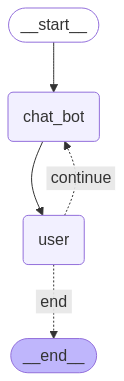

In [9]:
from IPython.display import Image, display

display(Image(simulation.get_graph(xray=True).draw_mermaid_png()))

In [10]:
for chunk in simulation.stream({"messages": []}):
    # Print out all events aside from the final end chunk
    if END not in chunk:
        print(chunk)
        print("----")

{'chat_bot': {'messages': [AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='60c1b439-7728-44a6-a1d4-942f045bb7ed')]}}
----
{'user': {'messages': [HumanMessage(content='안녕하세요! 제 이름은 해리슨입니다. 제가 5년 전에 알래스카로 향한 여행에 대한 환불을 받으려고 하는데 도와주실 수 있을까요?', additional_kwargs={}, response_metadata={}, id='02886362-7283-4ecd-a188-e38c74c0da43')]}}
----
{'chat_bot': {'messages': [AIMessage(content='안녕하세요 해리슨 님, 네, 저희가 도와드릴 수 있습니다. 여행 일자와 예약 번호를 알려주시면 확인해 보겠습니다.', additional_kwargs={}, response_metadata={}, id='384e3b6c-1ead-4d0a-ab00-f7675f309ca5')]}}
----
{'user': {'messages': [HumanMessage(content='알겠습니다. 제 여행 일자는 5년 전이었고, 예약 번호는 ABC123입니다. 전액 환불이 가능한지 확인해 주시길 바랍니다.', additional_kwargs={}, response_metadata={}, id='cf6b3bab-6712-47cd-807f-82a1d0cae8d5')]}}
----
{'chat_bot': {'messages': [AIMessage(content='해리슨 님, 감사합니다. 예약 내역을 확인해 보겠습니다. 저희가 처리해 드릴테니 잠시만 기다려 주세요. 확인 후에 결과를 알려드리도록 하겠습니다.조금만 기다려 주세요.결과가 나오는 대로 알려드리도록 하겠습니다.잠시만 기다려 주세요.', additional_kwargs={}, respon